* In this assignment you will be using the entire transformer architecture for a translation task.
* we will just be using one encoder layer and one decoder layer
* You can copy the encoder and decoder modules from the previous assignments. You are going to translate a few sentences from **English to Tamil**
  * Source language: English
  * Target language: Tamil

* You may experiment with a target language of your choice for checking the impelementation. (You may use google translate for that)

* We need to install torchdata and torchtext (which take about 3 minutes to finish installing) for tokenizing the text.
* We already defined useful functions for the tokenization of texts




In [ ]:
!pip install torchdata==0.6.0 # to be compatible with torch 2.0
!pip install portalocker==2.0.0
!pip install -U torchtext==0.15.1

* Let's import all required libraries

In [ ]:
import torch
from torch import Tensor

import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.nn.functional import one_hot

import torch.optim as optim

#text lib
import torchtext

# tokenizer
from torchtext.data.utils import get_tokenizer

#build vocabulary
from torchtext.vocab import vocab
from torchtext.vocab import build_vocab_from_iterator

# get input_ids (numericalization)
from torchtext.transforms import VocabTransform, LabelToIndex

# get embeddings
from torch.nn import Embedding

from  pprint import pprint
from yaml import safe_load
import copy
import numpy as np
import requests
import math

# Preparing Data

* Source and target text

In [ ]:
src_text = """The most famous ruler of ancient India was Emperor Ashoka.
It was during his period that Buddhism spread to different parts of Asia.
Ashoka gave up war after seeing many people grieving death after the Kalinga war.
He embraced Buddhism and then devoted his life to spread the message of peace and dharma.
His service for the cause of public good was exemplary.
He was the first ruler to give up war after victory.
He was the first to build hospitals for animals.
He was the first to lay roads."""

In [ ]:
tar_text = """பண்டைய இந்திய அரசர்களில் பேரும் புகழும் பெற்ற அரசர் அசோகர் ஆவார்.
இவரது ஆட்சியில் தான் புத்த மதம் ஆசியாவின் பல்வேறு பகுதிகளுக்குப் பரவியது.
கலிங்கப் போருக்குப் பின் பல உயிர்கள் மடிவதைக் கண்டு வருந்தி, போர் தொடுப்பதைக் கைவிட்டார்.
அதற்குப் பிறகு புத்த சமயத்தைத் தழுவி, அமைதியையும் அறத்தையும் பரப்புவதற்காகத் தன் வாழ்வையே அர்ப்பணித்தார்.
பொதுமக்களுக்கு அவர் ஆற்றிய சேவை முன் மாதிரியாக விளங்கியது.
வெற்றிக்குப் பின் போரைத் துறந்த முதல் அரசர் அசோகர்தான்.
உலகிலேயே முதன்முதலாக விலங்குகளுக்கும் தனியே மருத்துவமனை அமைத்துத் தந்தவரும் அசோகரே ஆவார்.
 இன்றும் அவர் உருவாக்கிய சாலைகளை நாம் பயன்படுத்திக்கொண்டு இருக்கிறோம்."""

* Tokenize and build vocabulary using a simple tokenization algorithm

In [ ]:
def seq_len(seq):
  return len(seq.strip('').split(' '))

# check the maximum length of the src and target seq to decide the context length of encdoer and decoder
src_raw_seq = src_text.strip('').split('\n')
src_max_seq_len =max(list(map(seq_len,src_raw_seq)))
print('Source max_seq_length:  ',src_max_seq_len)


tar_raw_seq = tar_text.strip('').split('\n')
tar_max_seq_len =max(list(map(seq_len,tar_raw_seq)))
print('Target max_seq_length: ',tar_max_seq_len)

Source max_seq_length:   16
Target max_seq_length:  11


* We encourage you to go through the code given below to understand the typical functionalities of Tokenizer object (If you want, you can skip)

In [ ]:
# do not edit this cell
class Tokenizer(object):

  def __init__(self,text):
    self.text = text
    self.word_tokenizer = self.word_tokenizer
    self.vocab_size = None
    self.vocab = None

  @staticmethod
  def word_tokenizer(seq):
    return seq.strip('').split(' ')

  def get_tokens(self):
    for sentence in self.text.strip().split('\n'):
      yield self.word_tokenizer(sentence)

  def build_vocab(self):
    self.vocab = build_vocab_from_iterator(self.get_tokens(),
                                  min_freq=1,specials=['<pad>','<start>','<end>','<unk>'])
    self.vocab.set_default_index(self.vocab['<unk>']) # index of OOV
    self.vocab_size = len(self.vocab)
    return self.vocab

  def encode(self,sentence):
    v = self.build_vocab()
    vt = VocabTransform(v)
    token_ids = vt(self.word_tokenizer(sentence))
    # add special tokens
    token_ids.insert(0,v.vocab.get_stoi()['<start>'])
    token_ids.append(v.vocab.get_stoi()['<end>']) # <end>:2
    return torch.tensor(token_ids,dtype=torch.int64)

  def decode(self,ids):
    v = self.build_vocab()
    list_ids = ids.tolist()
    tokens = [v.vocab.get_itos()[id] for id in list_ids]
    return ' '.join(tokens)

  def encode_batch(self,batch_size,max_seq_len):
    batch_data = torch.zeros(size=(batch_size,max_seq_len+2)) # +2 for special tokens
    for i,sentence in enumerate(self.text.strip('').split('\n')):
      token_ids = self.encode(sentence)
      batch_data[i,0:len(token_ids)] = token_ids
    return batch_data.type(dtype=torch.int64)



* It is always go to check the implementation

In [ ]:
batch_size = 8

In [ ]:
src_tokenizer = Tokenizer(src_text)
print(src_tokenizer.encode('The most famous ruler of ancient India was Emperor Ashoka.'))
print(src_tokenizer.encode_batch(batch_size,src_max_seq_len))

tensor([ 1, 27, 49, 39, 15,  8, 28, 24,  5, 22, 20,  2])
tensor([[ 1, 27, 49, 39, 15,  8, 28, 24,  5, 22, 20,  2,  0,  0,  0,  0,  0,  0],
        [ 1, 25,  5, 36, 14, 53, 58, 11, 16,  6, 35, 50,  8, 21,  2,  0,  0,  0],
        [ 1, 19, 40, 17, 18,  9, 56, 47, 52, 43, 32,  9,  4, 26, 61,  2,  0,  0],
        [ 1,  7, 37, 11, 12, 59, 33, 14, 46,  6, 16,  4, 48,  8, 51, 12, 34,  2],
        [ 1, 23, 57, 13,  4, 31,  8, 54, 42,  5, 38,  2,  0,  0,  0,  0,  0,  0],
        [ 1,  7,  5,  4, 10, 15,  6, 41, 17, 18,  9, 60,  2,  0,  0,  0,  0,  0],
        [ 1,  7,  5,  4, 10,  6, 30, 44, 13, 29,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  7,  5,  4, 10,  6, 45, 55,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0]])


In [ ]:
tar_tokenizer = Tokenizer(tar_text)
print(tar_tokenizer.encode('பண்டைய இந்திய அரசர்களில் பேரும் புகழும் பெற்ற அரசர் அசோகர் ஆவார்.'))
print(tar_tokenizer.encode_batch(batch_size,tar_max_seq_len))

tensor([ 1, 44, 22, 16, 53, 51, 52,  4, 11,  6,  2])
tensor([[ 1, 44, 22, 16, 53, 51, 52,  4, 11,  6,  2,  0,  0],
        [ 1, 25, 20, 39,  8, 59, 19, 49, 43, 47,  2,  0,  0],
        [ 1, 30, 55,  7, 48, 26, 58, 29, 65, 57, 41, 31,  2],
        [ 1, 13, 50,  8, 32, 38, 14, 18, 46, 37, 66, 17,  2],
        [ 1, 54,  5, 21, 34, 64, 61, 68,  2,  0,  0,  0,  0],
        [ 1, 69,  7, 56, 40, 63,  4, 12,  2,  0,  0,  0,  0],
        [ 1, 28, 62, 67, 36, 60, 15, 35, 10,  6,  2,  0,  0],
        [ 1,  9, 23,  5, 27, 33, 42, 45, 24,  2,  0,  0,  0]])


* Let's load the token ids of the words in the sentences of source and target languages

In [ ]:
x = src_tokenizer.encode_batch(batch_size,src_max_seq_len)
y = tar_tokenizer.encode_batch(batch_size,tar_max_seq_len)

* we have appended zeros to sentences that are shorter than max-seq-len
* We have to ignore computing loss over those padded tokens
* You have to take care of that in the cell below

In [ ]:
label = torch.where(y[:, 1:] == src_tokenizer.vocab['<pad>'], 0, y[:, 1:])
label = torch.cat([label, torch.zeros((label.size(0), 1), dtype=label.dtype, device=label.device)], dim=1)
label = label.int()
label

tensor([[44, 22, 16, 53, 51, 52,  4, 11,  6,  2,  0,  0,  0],
        [25, 20, 39,  8, 59, 19, 49, 43, 47,  2,  0,  0,  0],
        [30, 55,  7, 48, 26, 58, 29, 65, 57, 41, 31,  2,  0],
        [13, 50,  8, 32, 38, 14, 18, 46, 37, 66, 17,  2,  0],
        [54,  5, 21, 34, 64, 61, 68,  2,  0,  0,  0,  0,  0],
        [69,  7, 56, 40, 63,  4, 12,  2,  0,  0,  0,  0,  0],
        [28, 62, 67, 36, 60, 15, 35, 10,  6,  2,  0,  0,  0],
        [ 9, 23,  5, 27, 33, 42, 45, 24,  2,  0,  0,  0,  0]],
       dtype=torch.int32)

* Define the context lengths for encoder and decoder

In [ ]:
enc_ctxt_len = src_max_seq_len+2
dec_ctxt_len = tar_max_seq_len+2

# Load configuration file

In [ ]:
config_url = "https://raw.githubusercontent.com/Arunprakash-A/LLM-from-scratch-PyTorch/main/config_files/enc_config.yml"
response = requests.get(config_url)
config = response.content.decode("utf-8")
config = safe_load(config)
pprint(config)

{'input': {'batch_size': 10, 'embed_dim': 32, 'seq_len': 8, 'vocab_size': 10},
 'model': {'d_ff': 128,
           'd_model': 32,
           'dk': 4,
           'dq': 4,
           'dv': 4,
           'n_heads': 8,
           'n_layers': 6}}


In [ ]:
src_vocab_size =src_tokenizer.vocab_size
batch_size = x.shape[0]
embed_dim = config['input']['embed_dim']

In [ ]:
dq = torch.tensor(config['model']['dq'])
dk = torch.tensor(config['model']['dk'])
dv = torch.tensor(config['model']['dv'])
dmodel = embed_dim
heads = torch.tensor(config['model']['n_heads'])
d_ff = config['model']['d_ff']

In [ ]:
config_url = "https://raw.githubusercontent.com/Arunprakash-A/LLM-from-scratch-PyTorch/main/config_files/dec_config.yml"
response = requests.get(config_url)
config = response.content.decode("utf-8")
config = safe_load(config)
pprint(config)

{'input': {'batch_size': 10, 'embed_dim': 32, 'seq_len': 8, 'vocab_size': 12},
 'model': {'d_ff': 128,
           'd_model': 32,
           'dk': 4,
           'dq': 4,
           'dv': 4,
           'n_heads': 8,
           'n_layers': 6}}


In [ ]:
tar_vocab_size = tar_tokenizer.vocab_size

# Encoder

 * You can copy paste the required code from the previous assignments

In [ ]:
class MHA(nn.Module):
    def __init__(self, dmodel, dq, dk, dv, heads):
        super(MHA,self).__init__()
        self.dk = dk
        torch.manual_seed(43)
        self.WQ = nn.Parameter(torch.randn(heads, dmodel, dq))
        torch.manual_seed(44)
        self.WK = nn.Parameter(torch.randn(heads, dmodel, dk))
        torch.manual_seed(45)
        self.WV = nn.Parameter(torch.randn(heads, dmodel, dv))
        torch.manual_seed(46)
        self.WO = nn.Parameter(torch.randn(dmodel, dmodel))


    def forward(self, H):

        BS, T, _ = H.size()

        Q = torch.matmul(H.unsqueeze(1), self.WQ)
        K = torch.matmul(H.unsqueeze(1), self.WK)
        V = torch.matmul(H.unsqueeze(1), self.WV)

        scores = torch.matmul(Q, K.transpose(2, 3)) / np.sqrt(self.dk)
        attn_weights = torch.softmax(scores, dim=-1)
        attn_out = torch.matmul(attn_weights, V)
        attn_out = attn_out.permute(0,2,1,3).contiguous().view(BS, T, -1)
        out = torch.matmul(attn_out, self.WO)

        return out


class FFN(nn.Module):
    def __init__(self, dmodel, d_ff, layer=0):
        super(FFN, self).__init__()
        self.W1 = nn.Parameter(torch.randn((dmodel, d_ff), generator = torch.manual_seed(47)))
        self.b1 = nn.Parameter(torch.randn((d_ff), generator = torch.manual_seed(48)))
        self.W2 = nn.Parameter(torch.randn((d_ff, dmodel), generator = torch.manual_seed(49)))
        self.b2 = nn.Parameter(torch.randn((dmodel), generator = torch.manual_seed(50)))

    def forward(self, x):
        out = torch.matmul(x, self.W1) + self.b1
        out = nn.ReLU()(out)
        out = torch.matmul(out, self.W2) + self.b2
        return out


class EncoderLayer(nn.Module):

  def __init__(self,dmodel,dq,dk,dv,d_ff,heads):
    super(EncoderLayer,self).__init__()
    self.mha = MHA(dmodel,dq,dk,dv,heads)
    self.layer_norm_mha = torch.nn.LayerNorm(dmodel)
    self.ffn = FFN(dmodel,d_ff, layer=0)
    self.layer_norm_ffn = torch.nn.LayerNorm(dmodel)

  def forward(self,x):
    out = self.layer_norm_mha(self.mha(x)+x)
    out = self.layer_norm_ffn(self.ffn(out)+out)
    return out

class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, dq, dk, dv, d_ff, heads, num_layers=1):
        super(Encoder, self).__init__()
        base_layer = EncoderLayer(dmodel=embed_dim, dq=dq, dk=dk, dv=dv, d_ff=d_ff, heads=heads)
        self.encoder_layers = nn.ModuleList([
            copy.deepcopy(base_layer) for _ in range(num_layers)
        ])

    def forward(self, x):
        out = x
        for layer in self.encoder_layers:
            out = layer(out)
        return out

# Decoder

In [ ]:
class MHMA(nn.Module):
    def __init__(self, num_heads, model_dim, query_dim, key_dim, value_dim):
        super(MHMA, self).__init__()
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.query_dim = query_dim

        self.query_weights = nn.Parameter(torch.randn((num_heads, model_dim, query_dim), generator=torch.manual_seed(51)))
        self.key_weights = nn.Parameter(torch.randn((num_heads, model_dim, key_dim), generator=torch.manual_seed(52)))
        self.value_weights = nn.Parameter(torch.randn((num_heads, model_dim, value_dim), generator=torch.manual_seed(53)))
        self.output_weights = nn.Parameter(torch.randn((model_dim, model_dim), generator=torch.manual_seed(54)))

        nn.init.xavier_normal_(self.query_weights)
        nn.init.xavier_normal_(self.key_weights)
        nn.init.xavier_normal_(self.value_weights)
        nn.init.xavier_normal_(self.output_weights)

    def forward(self, query, key, value, mask):
        batch_size, seq_len, _ = query.shape
        query = torch.einsum('BSM, HMQ -> BHSQ', query, self.query_weights)
        key = torch.einsum('BSM, HMK -> BHSK', key, self.key_weights)
        value = torch.einsum('BSM, HMV -> BHSV', value, self.value_weights)

        attention_scores = torch.matmul(
            F.softmax((torch.matmul(query, key.transpose(-2, -1)) + mask) / math.sqrt(self.query_dim), dim=-1), value
        )
        combined_attention = attention_scores.permute(0, 2, 1, 3).contiguous().view(batch_size, seq_len, -1)
        output = torch.matmul(combined_attention, self.output_weights)

        return output


class MHCA(nn.Module):
    def __init__(self, num_heads, model_dim, query_dim, key_dim, value_dim):
        super(MHCA, self).__init__()
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.query_dim = query_dim

        self.query_weights = nn.Parameter(torch.randn((num_heads, model_dim, query_dim), generator=torch.manual_seed(55)))
        self.key_weights = nn.Parameter(torch.randn((num_heads, model_dim, key_dim), generator=torch.manual_seed(56)))
        self.value_weights = nn.Parameter(torch.randn((num_heads, model_dim, value_dim), generator=torch.manual_seed(57)))
        self.output_weights = nn.Parameter(torch.randn((model_dim, model_dim), generator=torch.manual_seed(58)))

        nn.init.xavier_normal_(self.query_weights)
        nn.init.xavier_normal_(self.key_weights)
        nn.init.xavier_normal_(self.value_weights)
        nn.init.xavier_normal_(self.output_weights)

    def forward(self, query, key, value):
        batch_size, seq_len, _ = query.shape
        query = torch.einsum('BSM, HMQ -> BHSQ', query, self.query_weights)
        key = torch.einsum('BSM, HMK -> BHSK', key, self.key_weights)
        value = torch.einsum('BSM, HMV -> BHSV', value, self.value_weights)

        attention_scores = torch.matmul(
            F.softmax(torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.query_dim), dim=-1), value
        )
        combined_attention = attention_scores.permute(0, 2, 1, 3).contiguous().view(batch_size, seq_len, -1)
        output = torch.matmul(combined_attention, self.output_weights)

        return output


class DecoderLayer(nn.Module):
    def __init__(self, model_dim, query_dim, key_dim, value_dim, ff_dim, num_heads, mask):
        super(DecoderLayer, self).__init__()
        self.self_attention = MHMA(num_heads, model_dim, query_dim, key_dim, value_dim)
        self.cross_attention = MHCA(num_heads, model_dim, query_dim, key_dim, value_dim)
        self.feed_forward = FFN(model_dim, ff_dim)
        self.layer_norm1 = nn.LayerNorm(model_dim)
        self.layer_norm2 = nn.LayerNorm(model_dim)
        self.layer_norm3 = nn.LayerNorm(model_dim)
        self.mask = mask

    def forward(self, encoder_output, decoder_input):
        attn_output = self.self_attention(decoder_input, decoder_input, decoder_input, self.mask)
        attn_output = self.layer_norm1(attn_output + decoder_input)

        cross_attn_output = self.cross_attention(attn_output, encoder_output, encoder_output)
        cross_attn_output = self.layer_norm2(cross_attn_output + attn_output)

        ff_output = self.feed_forward(cross_attn_output)
        output = self.layer_norm3(ff_output + cross_attn_output)

        return output


class Decoder(nn.Module):
    def __init__(self, vocab_size, model_dim, query_dim, key_dim, value_dim, ff_dim, num_heads, mask, num_layers):
        super(Decoder, self).__init__()
        self.decoder_layers = nn.ModuleList(
            [copy.deepcopy(DecoderLayer(model_dim, query_dim, key_dim, value_dim, ff_dim, num_heads, mask))
             for _ in range(num_layers)]
        )
        self.mask = mask

    def forward(self, encoder_output, decoder_input):
        output = decoder_input
        for layer in self.decoder_layers:
            output = layer(encoder_output, output)
        return output


class OutputLayer(nn.Module):
    def __init__(self, model_dim, vocab_size):
        super(OutputLayer, self).__init__()
        self.weight = nn.Parameter(torch.randn((model_dim, vocab_size), generator=torch.manual_seed(10)))
        self.bias = nn.Parameter(torch.randn((vocab_size), generator=torch.manual_seed(10)))

    def forward(self, x):
        output = torch.matmul(x, self.weight) + self.bias
        return output

# Positional Embedding

 * You may take the code directly from any source.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model, max_len):
        super(PositionalEncoding, self).__init__()

        pe = torch.arange(0, max_len*d_model).reshape(max_len, d_model).float()
        pe[0:,0::2] = torch.sin(torch.exp(torch.log(pe[0:, 0::2]%d_model)-(2*(pe[0:, 0::2]//d_model)/d_model)*torch.log(torch.tensor(10000))))
        pe[0:,1::2] = torch.cos(torch.exp(torch.log(pe[0:, 1::2]%d_model)-(2*(pe[0:, 1::2]//d_model)/d_model)*torch.log(torch.tensor(10000))))
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe
        return x


# Generate target mask

  * We will be passing the causal mask for the decoder layer as one of its arguments

In [ ]:
mask = (torch.triu(torch.ones(dec_ctxt_len,dec_ctxt_len)) == 1).transpose(0,1)
mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
print(mask)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


# Transformer

In [ ]:
class Transformer(nn.Module):

  def __init__(self,src_vocab_size,tar_vocab_size,src_seq_len,tar_seq_len,dmodel,dq,dk,dv,d_ff,heads,target_mask,num_layers=1):
      super(Transformer,self).__init__()
      self.src_embeddings = nn.Embedding(src_vocab_size,embed_dim)
      self.tar_embeddings = nn.Embedding(tar_vocab_size,embed_dim)
      self.src_pos_embeddings = PositionalEncoding(dmodel, src_seq_len)
      self.tar_pos_embeddings = PositionalEncoding(dmodel, tar_seq_len)
      self.encoder = Encoder(src_vocab_size,dmodel,dq,dk,dv,d_ff,heads,num_layers)
      self.decoder = Decoder(tar_vocab_size,dmodel,dq,dk,dv,d_ff,heads,target_mask,num_layers)
      self.output = OutputLayer(dmodel, tar_vocab_size)

  def forward(self,src_token_ids,tar_token_ids):

      out = self.encoder(self.src_pos_embeddings(self.src_embeddings(src_token_ids)))
      out = self.decoder(out,self.tar_pos_embeddings(self.tar_embeddings(tar_token_ids)))
      out = self.output(out)
      return out


In [ ]:
model = Transformer(src_vocab_size,tar_vocab_size,enc_ctxt_len,dec_ctxt_len,dmodel,dq,dk,dv,d_ff,heads,mask)

In [ ]:
model

Transformer(
  (src_embeddings): Embedding(62, 32)
  (tar_embeddings): Embedding(70, 32)
  (src_pos_embeddings): PositionalEncoding()
  (tar_pos_embeddings): PositionalEncoding()
  (encoder): Encoder(
    (encoder_layers): ModuleList(
      (0): EncoderLayer(
        (mha): MHA()
        (layer_norm_mha): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (ffn): FFN()
        (layer_norm_ffn): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (decoder): Decoder(
    (decoder_layers): ModuleList(
      (0): DecoderLayer(
        (self_attention): MHMA()
        (cross_attention): MHCA()
        (feed_forward): FFN()
        (layer_norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (layer_norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (layer_norm3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (output): OutputLayer()
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
import matplotlib.pyplot as plt

def train(src_token_ids, tar_token_ids, labels, model, criterion, optimizer, tar_vocab_size, dec_ctxt_len, batch_size, epochs=1000):
    loss_trace = []
    tf_epochs = int(epochs * 0.25)
    ar_epochs = epochs - tf_epochs

    print("Starting Training...")

    print("Teacher Forcing")
    for epoch in range(tf_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(src_token_ids, tar_token_ids)
        outputs = outputs.view(-1, tar_vocab_size)
        target = labels.view(-1)
        loss = criterion(outputs, target.long())

        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            loss_trace.append(loss.item())
            print(f"Epoch {epoch + 1}/{tf_epochs} | TF Loss: {loss.item():.4f}")


    print("Auto Regressive")
    for epoch in range(ar_epochs):
        tar_token_ids = torch.zeros((batch_size, dec_ctxt_len), dtype=torch.int).to(src_token_ids.device)
        tar_token_ids[:, 0] = 1

        for step in range(dec_ctxt_len - 1):
            model.train()
            optimizer.zero_grad()
            outputs = model(src_token_ids, tar_token_ids)
            outputs_flat = outputs.view(-1, tar_vocab_size)
            target_flat = labels.view(-1)

            loss = criterion(outputs_flat, target_flat.long())
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                predictions = torch.argmax(F.softmax(outputs, dim=-1), dim=-1)
                tar_token_ids[:, step + 1] = predictions[:, step]

            if (epoch + 1) % 10 == 0:
                loss_trace.append(loss.item())
                print(f"Epoch {epoch + 1}/{ar_epochs} | AR Loss: {loss.item():.4f}")


        loss_trace.append(loss.item())

    plt.figure(figsize=(10, 6))
    plt.plot(loss_trace, label='Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Training completed. Total iterations: {len(loss_trace)}")

    return outputs, loss_trace

Starting Training...
Teacher Forcing
Epoch 10/250 | TF Loss: 9.8029
Epoch 20/250 | TF Loss: 7.8297
Epoch 30/250 | TF Loss: 6.7456
Epoch 40/250 | TF Loss: 6.0258
Epoch 50/250 | TF Loss: 5.4432
Epoch 60/250 | TF Loss: 5.0041
Epoch 70/250 | TF Loss: 4.6547
Epoch 80/250 | TF Loss: 4.3708
Epoch 90/250 | TF Loss: 4.1358
Epoch 100/250 | TF Loss: 3.9417
Epoch 110/250 | TF Loss: 3.7701
Epoch 120/250 | TF Loss: 3.6146
Epoch 130/250 | TF Loss: 3.4775
Epoch 140/250 | TF Loss: 3.3524
Epoch 150/250 | TF Loss: 3.2345
Epoch 160/250 | TF Loss: 3.1230
Epoch 170/250 | TF Loss: 3.0169
Epoch 180/250 | TF Loss: 2.9165
Epoch 190/250 | TF Loss: 2.8194
Epoch 200/250 | TF Loss: 2.7257
Epoch 210/250 | TF Loss: 2.6373
Epoch 220/250 | TF Loss: 2.5508
Epoch 230/250 | TF Loss: 2.4685
Epoch 240/250 | TF Loss: 2.3886
Epoch 250/250 | TF Loss: 2.3122
Auto Regressive
Epoch 10/750 | AR Loss: 3.2212
Epoch 10/750 | AR Loss: 3.1530
Epoch 10/750 | AR Loss: 3.0584
Epoch 10/750 | AR Loss: 3.0067
Epoch 10/750 | AR Loss: 3.0261
E

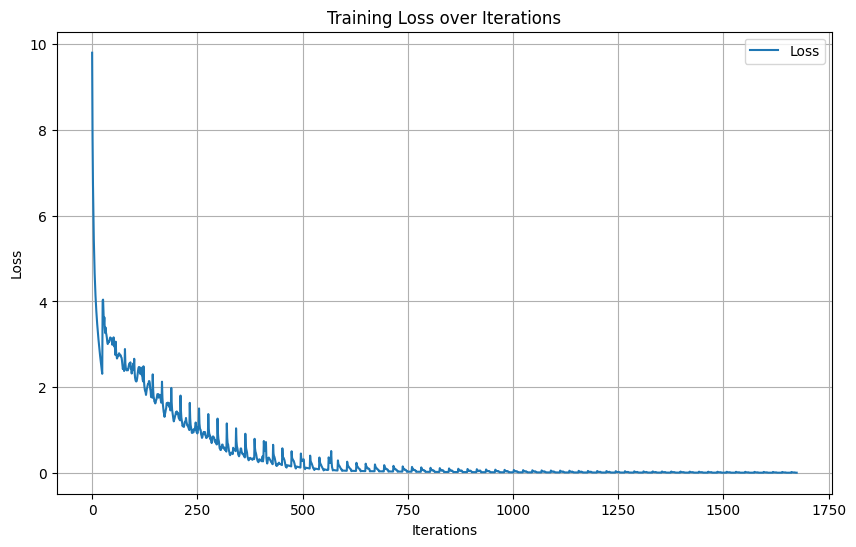

Training completed. Total iterations: 1675


In [ ]:
out, loss_trace = train(x,y,label,model,criterion, optimizer, tar_vocab_size, dec_ctxt_len, batch_size, epochs=1000)

## Run the model AutoRegressively

In [ ]:
@torch.inference_mode()
def inference(test_input):
  '''
  Run the model in autoregressive fashion and store the output at each time step in a list
  '''

  tar_token_ids = torch.zeros((1, dec_ctxt_len), dtype=torch.int)
  tar_token_ids[:, 0] = 1
  for item in range(dec_ctxt_len - 1):
    out = model(test_input.unsqueeze(0), tar_token_ids)
    pred = torch.argmax(F.softmax(out, dim=-1), dim=-1)
    tar_token_ids[:, item + 1] = pred[:, item]
  return tar_token_ids.squeeze(0)


* Modify the code below to suit your implementation
* Display the original and translated sentence (with all the spcial tokens)
* Note that, the second half of the second sentence is poorly translated
*  Same goes for 3rd and 4th sentence
* All other sentences are properly translated

In [ ]:
for token_ids in x:
  print(src_tokenizer.decode(token_ids))
  print(tar_tokenizer.decode(inference(token_ids)))

<start> The most famous ruler of ancient India was Emperor Ashoka. <end> <pad> <pad> <pad> <pad> <pad> <pad>
<start> பண்டைய இந்திய அரசர்களில் பேரும் புகழும் பெற்ற அரசர் அசோகர் ஆவார். <end> <pad> <pad>
<start> It was during his period that Buddhism spread to different parts of Asia. <end> <pad> <pad> <pad>
<start> இவரது ஆட்சியில் தான் புத்த மதம் ஆசியாவின் பல்வேறு பகுதிகளுக்குப் பரவியது. <end> <pad> <pad>
<start> Ashoka gave up war after seeing many people grieving death after the Kalinga war. <end> <pad> <pad>
<start> கலிங்கப் போருக்குப் பின் பல உயிர்கள் மடிவதைக் கண்டு வருந்தி, போர் தொடுப்பதைக் கைவிட்டார். <end>
<start> He embraced Buddhism and then devoted his life to spread the message of peace and dharma. <end>
<start> அதற்குப் பிறகு புத்த சமயத்தைத் தழுவி, அமைதியையும் அறத்தையும் பரப்புவதற்காகத் தன் வாழ்வையே அர்ப்பணித்தார். <end>
<start> His service for the cause of public good was exemplary. <end> <pad> <pad> <pad> <pad> <pad> <pad>
<start> பொதுமக்களுக்கு அவர் ஆற்றிய சேவை முன் மாதிரி